In [2]:
# import sys
# import os
# import cv2
# import jetbot
# import numpy as np
# import traitlets
# import control_utils
# from ipywidgets import Image, VBox
# from IPython.display import display
# from jetbot import bgr8_to_jpeg, Camera

# print(sys.executable)
# print(cv2.__file__)
# print(control_utils.__file__)
# print(jetbot.__file__)

/usr/bin/python3
/usr/lib/python3.6/dist-packages/cv2/python-3.6/cv2.cpython-36m-aarch64-linux-gnu.so
/workspace/skarpety/src/control_utils.py
/usr/local/lib/python3.6/dist-packages/jetbot-0.4.3-py3.6.egg/jetbot/__init__.py


In [1]:
import torch
from torchvision import models, transforms
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg
from scipy.spatial.distance import cosine
import numpy as np
from PIL import Image

camera = Camera.instance(width=300, height=300)
image = widgets.Image(format='jpeg', width=300, height=300)  # this width and height doesn't necessarily have to match the camera
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
display(image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [2]:
floor_prototype = np.load("../models/floor_prototype_full.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Usunięcie ostatniej warstwy
model = model.to(device)
model.eval()  # Tryb ewaluacji

def is_floor():
    image = Image.fromarray(camera.value)

    # Przekształcenie fragmentu na embedding
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    fragment_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        embedding = model(fragment_tensor).cpu().numpy().flatten()
        distance = cosine(embedding, floor_prototype)

    print(f"Odległość kosinusowa = {distance:.4f}")
    return distance

In [6]:
import matplotlib.pyplot as plt
import time
import math

# TURN_SPEED = 0.2
# Czas obrotu o 30°: 2.34 sekundy
# Czas obrotu o 45°: 3.51 sekundy
# Czas obrotu o 60°: 4.68 sekundy
# Czas obrotu o 90°: 7.02 sekundy

# Parametry sterowania
FORWARD_SPEED = 0.8
TURN_SPEED = 0.6
TURN_TIME = 2.34  # Czas obrotu w sekundach
DELAY = 0.1     # Czas odświeżania pętli w sekundach

# Inicjalizacja mapy
path = [(0, 0)]  # Lista współrzędnych (x, y) robota
x, y = 0, 0      # Początkowe współrzędne
direction = 0    # Kierunek w stopniach (0 = góra, 90 = prawo, 180 = dół, 270 = lewo)

def draw_path(path):
    """
    Rysuje przebytą drogę na mapie.
    :param path: Lista współrzędnych (x, y).
    """
    xs, ys = zip(*path)
    plt.plot(xs, ys, marker='o')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Przebyta droga robota")
    plt.grid()
    plt.show()

def move_forward(robot):
    """
    Porusza robotem do przodu.
    """
    robot.left_motor.value = FORWARD_SPEED
    robot.right_motor.value = FORWARD_SPEED

def stop(robot):
    """
    Zatrzymuje robota.
    """
    robot.left_motor.value = 0
    robot.right_motor.value = 0
    
def turn_by_angle(robot, angle, turn_speed=TURN_SPEED):
    """
    Obraca robota o określony kąt, uwzględniając prędkość obrotu.
    :param robot: Obiekt robota.
    :param angle: Kąt w stopniach (dodatni = w prawo, ujemny = w lewo).
    :param turn_speed: Prędkość obrotu (zakres od 0.1 do 1.0).
    """
    # Bazowy czas obrotu o 90° dla TURN_SPEED=0.2
    base_turn_speed = 0.2
    base_time_90 = 7.02  # czas obrotu o 90° przy prędkości 0.2

    # Oblicz czas obrotu dla 90° przy zadanej prędkości
    turn_time_90 = base_time_90 * (base_turn_speed / turn_speed)

    # Oblicz czas obrotu dla zadanego kąta
    abs_angle = abs(angle)
    turn_time = turn_time_90 * (abs_angle / 90)

    # Kierunek obrotu
    if angle > 0:  # Obrót w prawo
        robot.left_motor.value = turn_speed
        robot.right_motor.value = -turn_speed
    else:  # Obrót w lewo
        robot.left_motor.value = -turn_speed
        robot.right_motor.value = turn_speed

    # Obrót przez określony czas
    time.sleep(turn_time)
    robot.left_motor.value = 0
    robot.right_motor.value = 0

    print(f"Obrót o {angle}° zakończony w czasie {turn_time:.2f} sekundy (prędkość: {turn_speed}).")


def update_position(x, y, direction, step=1):
    """
    Aktualizuje pozycję robota w oparciu o aktualny kierunek i krok.
    :param x: Aktualna współrzędna x.
    :param y: Aktualna współrzędna y.
    :param direction: Kierunek w stopniach (0 = góra, 90 = prawo, itd.).
    :param step: Krok przesunięcia (dystans przebywany w jednym ruchu).
    :return: Nowe współrzędne (x, y).
    """
    direction_radians = math.radians(direction)
    new_x = x + step * math.cos(direction_radians)
    new_y = y + step * math.sin(direction_radians)
    return new_x, new_y

def move_and_print():
    global direction, x, y, path
    try:
        print("Rozpoczęcie jazdy. Naciśnij Ctrl+C, aby zatrzymać.")
        has_turned = False  # Flaga: Czy robot ostatnio skręcał?
        turn_direction = None  # Kierunek ostatniego skrętu: 'left' lub 'right'

        while True:
            # Przechwyć obraz z kamery
            frame = camera.value
            if frame is not None:
                image = Image.fromarray(frame)

                # Sprawdź, czy przed robotem jest podłoga
                forward_distance = is_floor()

                if forward_distance < 0.175:  # Jeśli podłoga wykryta
                    print(f"Podłoga wykryta. Jedź do przodu. Odległość: {forward_distance:.4f}")
                    move_forward(robot)

                    # Aktualizacja pozycji robota
                    x, y = update_position(x, y, direction, step=1)
                    path.append((x, y))
                    time.sleep(DELAY)  # Jedź chwilę do przodu

                    # Resetuj flagę i kierunek skrętu, bo robot jedzie prosto
                    has_turned = False
                    turn_direction = None
                else:
                    print(f"Brak podłogi przed robotem. Odległość: {forward_distance:.4f}")
                    stop(robot)

                    if has_turned:
                        # Kontynuowanie skrętu w wybranym kierunku
                        print(f"Kontynuowanie skrętu w kierunku: {turn_direction}")
                        if turn_direction == 'left':
                            turn_by_angle(robot, -30)
                            direction = (direction - 30) % 360
                        elif turn_direction == 'right':
                            turn_by_angle(robot, 30)
                            direction = (direction + 30) % 360
                    else:
                        # Rozejrzenie się i wybór najlepszego kierunku
                        print("Rozejrzenie się...")
                        turn_by_angle(robot, -15)  # Obrót w lewo o 15°
                        left_distance = is_floor()

                        turn_by_angle(robot, 30)  # Obrót w prawo o 30° (15° w prawo od pozycji wyjściowej)
                        right_distance = is_floor()

                        # Powrót do pozycji początkowej (15° w lewo od pozycji prawej)
                        turn_by_angle(robot, -15)

                        # Wybór kierunku
                        if left_distance < right_distance:
                            print(f"Skręt w lewo o 30°. Odległość w lewo: {left_distance:.4f}")
                            turn_by_angle(robot, -30)
                            direction = (direction - 30) % 360
                            turn_direction = 'left'
                        else:
                            print(f"Skręt w prawo o 30°. Odległość w prawo: {right_distance:.4f}")
                            turn_by_angle(robot, 30)
                            direction = (direction + 30) % 360
                            turn_direction = 'right'

                        # Ustaw flagę, że robot już się rozglądał i wybrał kierunek
                        has_turned = True

    except KeyboardInterrupt:
        print("Zatrzymano robota.")
    finally:
        stop(robot)
        # Rysowanie przebytej drogi
        draw_path(path)

    


In [7]:
#control_utils.resetCameraPosition()

Rozpoczęcie jazdy. Naciśnij Ctrl+C, aby zatrzymać.
Odległość kosinusowa = 0.1575
Podłoga wykryta. Jedź do przodu. Odległość: 0.1575
Odległość kosinusowa = 0.1432
Podłoga wykryta. Jedź do przodu. Odległość: 0.1432
Odległość kosinusowa = 0.1592
Podłoga wykryta. Jedź do przodu. Odległość: 0.1592
Odległość kosinusowa = 0.1872
Brak podłogi przed robotem. Odległość: 0.1872
Rozejrzenie się...
Obrót o -15° zakończony w czasie 0.39 sekundy (prędkość: 0.6).
Odległość kosinusowa = 0.1829
Obrót o 30° zakończony w czasie 0.78 sekundy (prędkość: 0.6).
Odległość kosinusowa = 0.1787
Obrót o -15° zakończony w czasie 0.39 sekundy (prędkość: 0.6).
Skręt w prawo o 30°. Odległość w prawo: 0.1787
Obrót o 30° zakończony w czasie 0.78 sekundy (prędkość: 0.6).
Odległość kosinusowa = 0.1530
Podłoga wykryta. Jedź do przodu. Odległość: 0.1530
Odległość kosinusowa = 0.1766
Brak podłogi przed robotem. Odległość: 0.1766
Rozejrzenie się...
Obrót o -15° zakończony w czasie 0.39 sekundy (prędkość: 0.6).
Odległość kosin

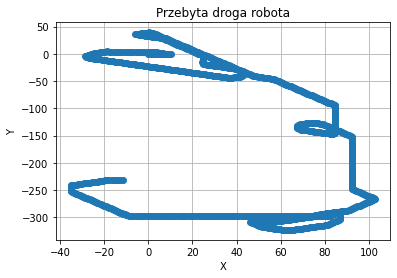

In [7]:
import threading
from time import sleep
from jetbot import Robot
from SCSCtrl import TTLServo

robot = Robot()

move_and_print()